<a href="https://colab.research.google.com/github/pablohenrique93/projeto-de-etl-comunicacao-de-acidente-de-trabalho-cat/blob/main/projeto_etl_cat_ivana_pablo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Realizar um processo de ETL que consolide as bases disponibilizadas em somente uma base consolidada com os seguintes requisitos 


A base de dados 
Disponibilização dos dados de CAT, cadastradas no sistema informatizado de Comunicação de Acidentes do Trabalho do INSS (CATWEB) ou quando da concessão de benefício por incapacidade acidentário, observado o disposto no Decreto nº 8.777/16 e Lei de Acesso à Informação nº 12.527/2011.


-As bases disponibilizadas contém o ano de 2022 separadas por meses(coluna de controle) , a mesma é informada por sistema , telefone e ou presencial então provável existirem dados divergentes ou ausentes(faltantes)

Nivel Infra
O arquivo original e tratado deve ser salvo em MongoDB Atlas em coleções diferentes (enumerar com o final trat ou orig)
Os Datasets devem ser obrigatoriamente salvos em uma bucket do CloudStorage(original e tratado)
Disponibilizar o dataset final em um mysql

Nivel Pandas
Realizar a extração correta para um dataframe.
Verificar a existência de dados inconsistentes e realizar a limpeza para NaN/NA ou algum valor atribuído por você explicando o porque da decisão.
Realizar o drop(se necessário) de colunas do dataframe realizando o comentário do porque da exclusão 
Todos os passos devem ser comentados(exclusivos)
Agregar todos os DF's originais em um unico DF tratado
Criar no mínimo 3 insights dos dados apresentados podendo ser construído com auxilio de plots

Nivel PySpark (Funções básicas vistas em aula)
Deverá ser montada a estrutura do DataFrame utilizando o StructType.
Verificar a existência de dados inconsistentes, nulos e realizar a limpeza.
Verificar a necessidade de drop em colunas ou linhas. Caso seja necessário, fazer comentário do porque.

Realizar a mudança de nome de pelo menos 2 colunas
Deverá criar pelo menos duas novas colunas contendo alguma informação relevante sobre as outras colunas já existentes (Funções de Agrupamento, Agregação ou Joins). (Use a sua capacidade analítica)
Deverá utilizar filtros, ordenação e agrupamento, trazendo dados relevantes para o negócio em questão. (Use a sua capacidade analítica)
Utilizar pelo menos duas Window Functions
5 insights utilizando SparkSQL


Ferramentas


Colab ou Ides | Google Cloud


Observação : o que será analisado são os tópicos cumpridos , na ocasião de findar o tempo e algum(ns) não forem contemplados , realize a entrega do que foi concluído . Pedimos que nos conceda acesso ao email professores.bcw4@soulcodeacademy.org para seu projeto no google cloud , crie um certificado(token) no mongo atlas e compartilhe junto a key de autenticação para acessarmos seu mongo atlas e seja enviado juntamente com o código realizado(link colab).

### INSTALAÇÃO BIBLIOTECAS

In [ ]:
#INSTALAÇÃO DO PANDERA, PYSPARK E GOOGLE CLOUD RESPECTIVAMENTE.
!pip install PYSPARK
!pip install gcsfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 199 kB 19.7 MB/s 
  Created wheel for PYSPARK: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=afd16313f41f99f3d70dcaaef84fb117ba9b59accb3591f9ed74110e6f0a6ed0
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built PYSPARK
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### IMPORTAÇÃO BIBLIOTECAS

In [ ]:
#IMPORTAÇÃO DAS BIBLIOTECAS 
from pyspark.sql import SparkSession
import pyspark.sql.functions
from pyspark.sql.functions import *
import os
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
from pyspark.sql.window import Window
from google.cloud import storage
from pyspark.sql.types import *
import pymongo
from pymongo import MongoClient

# EXTRAÇÃO DA BASE DE DADOS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
serviceAccount = '/content/aulas-bc26-ivana-b8f6bd3e55b9.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

In [ ]:
# FAZER ACESSO AO BUCKET
client = storage.Client()
#client = storage.Client()
# CRIAR UMA VARIÁVEL PARA RECEBER O NOME DA BUCKET
bucket = client.get_bucket('bc26-datasets-ivana')
blob1 = bucket.blob('D.SDA.PDA.005.CAT.202201 - D.SDA.PDA.005.CAT.202201_orig.csv')
blob2 = bucket.blob('D.SDA.PDA.005.CAT.202204 - D.SDA.PDA.005.CAT.202204_orig.csv')
blob3 = bucket.blob('D.SDA.PDA.005.CAT.202210 - D.SDA.PDA.005.CAT.202210_orig.csv')
# CRIAR UMA VARIÁVEL PARA RECEBER O CAMINHO DO ARQUIVO
path1 ='gs://bc26-datasets-ivana/projeto aquecimento/D.SDA.PDA.005.CAT.202201 - D.SDA.PDA.005.CAT.202201_orig.csv'
path2 = 'gs://bc26-datasets-ivana/projeto aquecimento/D.SDA.PDA.005.CAT.202204 - D.SDA.PDA.005.CAT.202204_orig.csv'
path3 = 'gs://bc26-datasets-ivana/projeto aquecimento/D.SDA.PDA.005.CAT.202210 - D.SDA.PDA.005.CAT.202210_orig.csv'
df_pd_1 = pd.read_csv(path1, low_memory=False)
df_pd_2 = pd.read_csv(path2, low_memory=False)
df_pd_3 = pd.read_csv(path3, low_memory=False)

# PRÉ-ANALISE DOS DF'S ORIGINAIS

In [ ]:
#ANÁLISE DOS DF1, DF2 E DF3 RESPECTIVAMENTE
df_pd_1.head(100)

In [ ]:
#VERFICAÇÃO DA TIPAGEM DAS COLUNAS
df_pd_1.dtypes

In [ ]:
df_pd_2.dtypes

Agente  Causador  Acidente     object
Data Acidente                  object
CBO                            object
CID-10                         object
CNAE2.0 Empregador              int64
CNAE2.0 Empregador.1           object
Emitente CAT                   object
Espécie do benefício           object
Filiação Segurado              object
Indica Óbito Acidente          object
Munic Empr                     object
Natureza da Lesão              object
Origem de Cadastramento CAT    object
Parte Corpo Atingida           object
Sexo                           object
Tipo do Acidente               object
UF  Munic.  Acidente           object
UF Munic. Empregador           object
Data Acidente.1                object
Data Despacho Benefício        object
Data Acidente.2                object
Data Nascimento                object
Data Emissão CAT               object
CNPJ/CEI Empregador            object
dtype: object

In [ ]:
df_pd_3.dtypes

Agente  Causador  Acidente     object
Data Acidente                  object
CBO                            object
CID-10                         object
CNAE2.0 Empregador              int64
CNAE2.0 Empregador.1           object
Emitente CAT                   object
Espécie do benefício           object
Filiação Segurado              object
Indica Óbito Acidente          object
Munic Empr                     object
Natureza da Lesão              object
Origem de Cadastramento CAT    object
Parte Corpo Atingida           object
Sexo                           object
Tipo do Acidente               object
UF  Munic.  Acidente           object
UF Munic. Empregador           object
Data Acidente.1                object
Data Despacho Benefício        object
Data Acidente.2                object
Data Nascimento                object
Data Emissão CAT               object
CNPJ/CEI Empregador            object
dtype: object

In [ ]:
df_pd_1.shape

(152140, 24)

In [ ]:
df_pd_2.shape

(89602, 24)

In [ ]:
df_pd_3.shape

In [ ]:
df_pd_1.count

In [ ]:
df_pd_2.count

In [ ]:
df_pd_3.count

In [ ]:
df_pd_1.head(10)

In [ ]:
df_pd_2.head(10)

# VERIFICAÇÃO DE INCONSISTÊNCIAS NOS DF'S INDIVIDUALMENTE

In [ ]:
#POR MOTIVOS DE PROCESSAMENTO OPTAMOS POR VERIFICAR A COLUNA 'CNPJ/CEI Empregador' INDIVIDUALMENTE DE CADA DF.

'df_pd_1'

valores_estranhos = []
for i in range(len(df_pd_1)):
  try:
    int(df_pd_1.loc[i , 'CNPJ/CEI Empregador'])
  except Exception:
    valores_estranhos.append(df_pd_1.loc[i , 'CNPJ/CEI Empregador'])
print(valores_estranhos)


['57.571.275.002.570', '19.578.086.000.162', '19.578.086.000.162', '24.574.403.000.102', '57.571.275.002.570', '76.417.005.000.429', '57.571.275.002.570', '72.962.202.000.125', '88.625.686.000.742', '9.356.818.000.116', '14.591.222.000.726', '36.448.137.000.150', '36.448.137.000.150', '27.665.906.001.404', '3.788.239.000.166', '31.237.773.004.298', '5.965.861.000.128', '88.625.686.000.742', '36.448.137.000.150', '9.463.468.000.278', '20.430.120.000.136', '1.882.547.000.120', '21.382.943.000.287', '11.212.177.000.178', '97.547.022.000.108', '3.788.239.000.166', '35.807.379.000.120', '78.614.971.000.208', '27.008.172.000.168', '27.997.377.000.113', '85.294.759.000.187', '57.571.275.002.570', '27.413.891.000.164', '31.288.446.000.197', '82.009.572.000.104', '31.785.541.000.104', '78.614.971.000.380', '16.444.804.000.110', '57.038.952.000.111', '34.125.812.000.185', '43.240.043.000.157', '62.249.362.000.178', '16.444.804.000.110', '57.571.275.002.570', '40.184.151.000.161', '61.372.058.000

In [ ]:
'df_pd_2'

valores_estranhos = []
for i in range(len(df_pd_2)):
  try:
    int(df_pd_2.loc[i , 'CNPJ/CEI Empregador'])
  except Exception:
    valores_estranhos.append(df_pd_2.loc[i , 'CNPJ/CEI Empregador'])
print(valores_estranhos)

['57.571.275.002.570', '57.571.275.002.570', '47.715.347.000.184', '38.300.481.000.123', '46.020.301.000.269', '57.571.275.002.570', '57.571.275.002.570', '57.571.275.002.570', '21.186.804.000.105', '15.581.467.000.220', '23.647.209.000.147', '33.722.224.000.166', '57.571.275.003.037', '44.704.381.000.165', '57.571.275.001.840', '23.647.209.000.147', '886.257.000.192', '4.208.852.000.120', '10.876.637.000.108', '23.647.209.000.147', '83.192.096.000.164', '47.673.793.021.413', '23.354.848.000.114', '11.419.410.000.198', '38.003.406.000.109', '4.228.734.000.183', '63.025.530.008.512', '20.533.295.000.250', '47.673.793.007.003', '57.571.275.001.417', '50.460.351.000.153', '41.717.569.000.150', '46.446.696.000.185', '11.344.038.002.060', '20.356.580.000.161', '39.223.581.000.166', '85.495.158.000.132', '95.440.517.000.108', '5.066.213.000.130', '16.692.121.000.181', '21.051.795.000.137', '13.676.788.000.100', '7.818.313.000.796', '47.078.019.002.249', '2.250.663.000.190', '31.601.909.000.1

In [ ]:
'df_pd_3'

valores_estranhos = []
for i in range(len(df_pd_3)):
  try:
    int(df_pd_3.loc[i , 'CNPJ/CEI Empregador'])
  except Exception:
    valores_estranhos.append(df_pd_3.loc[i , 'CNPJ/CEI Empregador'])
print(valores_estranhos)

['57.571.275.001.336', '18.715.599.000.105', '46.823.388.000.121', '57.571.275.002.570', '57.571.275.002.570', '15.313.027.000.101', '18.715.383.000.140', '45.276.128.000.110', '35.471.461.000.127', '18.602.102.000.142', '60.448.040.000.122', '29.254.010.000.135', '60.746.948.000.112', '17.261.661.000.173', '47.611.306.003.082', '26.650.078.000.145', '3.501.509.000.106', '46.137.444.000.174', '22.148.707.000.182', '1.870.160.000.154', '45.370.087.000.127', '83.303.404.000.181', '4.885.197.000.144', '16.829.640.000.149', '28.413.401.000.273', '31.329.124.000.149', '60.701.190.033.029', '45.787.660.000.100', '60.701.190.390.131', '27.142.058.000.126', '44.386.221.000.115', '33.787.094.002.789', '90.400.888.000.142', '62.871.462.000.131', '1.119.993.000.188', '23.568.742.000.113', '18.428.839.000.190', '5.451.496.000.133', '33.787.094.000.140', '41.685.308.000.103', '19.876.424.000.142', '92.931.245.000.150', '88.625.686.002.443', '28.812.972.000.108', '45.152.139.000.199', '76.417.005.00

In [ ]:
df_pd_3.dtypes

Agente  Causador  Acidente     object
Data Acidente                  object
CBO                            object
CID-10                         object
CNAE2.0 Empregador              int64
CNAE2.0 Empregador.1           object
Emitente CAT                   object
Espécie do benefício           object
Filiação Segurado              object
Indica Óbito Acidente          object
Munic Empr                     object
Natureza da Lesão              object
Origem de Cadastramento CAT    object
Parte Corpo Atingida           object
Sexo                           object
Tipo do Acidente               object
UF  Munic.  Acidente           object
UF Munic. Empregador           object
Data Acidente.1                object
Data Despacho Benefício        object
Data Acidente.2                object
Data Nascimento                object
Data Emissão CAT               object
CNPJ/CEI Empregador            object
dtype: object

In [ ]:
df_pd_3.dtypes

Agente  Causador  Acidente     object
Data Acidente                  object
CBO                            object
CID-10                         object
CNAE2.0 Empregador              int64
CNAE2.0 Empregador.1           object
Emitente CAT                   object
Espécie do benefício           object
Filiação Segurado              object
Indica Óbito Acidente          object
Munic Empr                     object
Natureza da Lesão              object
Origem de Cadastramento CAT    object
Parte Corpo Atingida           object
Sexo                           object
Tipo do Acidente               object
UF  Munic.  Acidente           object
UF Munic. Empregador           object
Data Acidente.1                object
Data Despacho Benefício        object
Data Acidente.2                object
Data Nascimento                object
Data Emissão CAT               object
CNPJ/CEI Empregador            object
dtype: object

# CONCATENAÇÃO DOS DF'S ORIGINAIS

In [ ]:
# CONCATENAÇÃO DOS 3 DF'S ORIGINAIS PARA UM ÚNICO DF
df_pd_final = [df_pd_1, df_pd_2, df_pd_3]
df_pd_final = pd.concat(df_pd_final)

In [ ]:
df_pd_final_teste = df_pd_final.copy
df_pd_final_teste = df_pd_final

In [ ]:
df_pd_final_teste.dtypes

Agente  Causador  Acidente     object
Data Acidente                  object
CBO                            object
CID-10                         object
CNAE2.0 Empregador              int64
CNAE2.0 Empregador.1           object
Emitente CAT                   object
Espécie do benefício           object
Filiação Segurado              object
Indica Óbito Acidente          object
Munic Empr                     object
Natureza da Lesão              object
Origem de Cadastramento CAT    object
Parte Corpo Atingida           object
Sexo                           object
Tipo do Acidente               object
UF  Munic.  Acidente           object
UF Munic. Empregador           object
Data Acidente.1                object
Data Despacho Benefício        object
Data Acidente.2                object
Data Nascimento                object
Data Emissão CAT               object
CNPJ/CEI Empregador            object
dtype: object

In [ ]:
# ENVIO DO DF CONCATENADO PARA A BUCKET NA GCP
df_pd_final.to_csv('gs://bc26-datasets-ivana/catweb_orig_export.csv',
               storage_options={'token':'/content/aulas-bc26-ivana-b8f6bd3e55b9.json'}
)

In [ ]:
#CONTAGEM DO TOTAL DE LINHAS NO DF
len(df_pd_final.index)

257401

# BACKUP DOS DF'S

In [ ]:
#ANTES DE INICIAR O TRATAMENTO DE DADOS FAZ-SE NECESSÁRIO UM BACKUP, PARA EM CASO DE UM POSSÍVEL ERRO, OS DADOS ESTAREM ASSEGURADOS
bckup_df_pd_1 = df_pd_1.copy
bckup_df_pd_2 = df_pd_2.copy
bckup_df_pd_3 = df_pd_3.copy
bckup_df_pd_final = df_pd_final.copy

#ENVIO DOS DF'S PARA O MongoDB

In [ ]:
#CONECTOR DO MONGO ATLAS
uri = "uri_mongo_db"
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile='certificate_key')

In [ ]:
#ESCOLHA DO DATABASE E COLEÇÃO - ORIG
db = client['catweb_db_orig'] #DATABASE
colecao_catweb = db['catweb_orig'] #COLEÇÃO
#db_tratado = client['catweb_db_tratado']
#collection_tratado = db['catweb_tratado']

In [ ]:
#ENVIO DOS DF'S POR PARTES 1/2/3 RESPECTIVAMENTE
df_pd_1_dict = df_pd_1.to_dict("records")
colecao_catweb.insert_many(df_pd_1_dict)

In [ ]:
df_pd_2_dict = df_pd_2.to_dict("records")
colecao_catweb.insert_many(df_pd_2_dict)

In [ ]:
df_pd_3_dict = df_pd_3.to_dict("records")
colecao_catweb.insert_many(df_pd_3_dict)

In [ ]:
colecao_catweb.count_documents({})

247718

In [ ]:
#ENVIO DO DF CONCATENADO 
df_pd_final_dict = df_pd_final.to_dict("records")
colecao_catweb.insert_many(df_pd_final_dict)

# PRÉ-ANÁLISE DO DF CONCATENADO

In [ ]:
#PRÉ ANÁLISE COM O OBJETIVO DE ANALISAR O DF CONCATENADO/DISPOSIÇÃO DAS COLUNAS ASSIM COMO A PRÉVIA DE COMO ESTÃO A TIPAGEM DAS COLUNAS.

In [ ]:
df_pd_final.dtypes

In [ ]:
df_pd_final.shape

(257401, 24)

In [ ]:
df_pd_final.count

In [ ]:
df_pd_final.head(10)

In [ ]:
df_pd_final.tail(10)

In [ ]:
pd.set_option('display.max_columns',100)

In [ ]:
df_pd_3.tail(10)

In [ ]:
df_pd_2.tail(10)

In [ ]:
df_pd_1.tail(10)

In [ ]:
df_pd_3.head(10)

# TRATAMENTO DE DADOS

---



In [ ]:
#VERIFICAÇÃO DE CADA COLUNA COM O OBJETIVO DE ENCONTRAR POSSÍVEIS INCONSISTÊNCIAS.

In [ ]:
df_pd_final.head()

In [ ]:
pd.unique(df_pd_final['Agente  Causador  Acidente'])

In [ ]:
pd.unique(df_pd_final['Data Acidente'])

In [ ]:
pd.unique(df_pd_final['CBO'])

In [ ]:
pd.unique(df_pd_final['CID-10'])

In [ ]:
pd.unique(df_pd_final['CNAE2.0 Empregador'])

In [ ]:
pd.unique(df_pd_final['CNAE2.0 Empregador.1'])

In [ ]:
pd.unique(df_pd_final['Emitente CAT'])

In [ ]:
pd.unique(df_pd_final['Espécie do benefício'])

In [ ]:
pd.unique(df_pd_final['Filiação Segurado'])

In [ ]:
pd.unique(df_pd_final['Indica Óbito Acidente']) 

In [ ]:
pd.unique(df_pd_final['Munic Empr'])

In [ ]:
pd.unique(df_pd_final['Natureza da Lesão'])

In [ ]:
pd.unique(df_pd_final['Origem de Cadastramento CAT'])

array(['Internet', '{ñ class'], dtype=object)

In [ ]:
pd.unique(df_pd_final['Parte Corpo Atingida'])

In [ ]:
pd.unique(df_pd_final['Sexo'])

In [ ]:
pd.unique(df_pd_final['Tipo do Acidente'])

In [ ]:
pd.unique(df_pd_final['UF  Munic.  Acidente'])

array(['Maranhão', '{ñ class}', 'Pará', 'Roraima', 'Zerado', 'Ceará',
       'Rondônia', 'Amazonas', 'Tocantins', 'Pernambuco', 'Acre',
       'Sergipe', 'Rio Grande Norte', 'Amapá', 'Paraíba', 'Alagoas',
       'Piauí'], dtype=object)

In [ ]:
pd.unique(df_pd_final['UF Munic. Empregador'])

array(['São Paulo', 'Goiás', 'Bahia', 'Pernambuco', 'Paraná', 'Ceará',
       'Santa Catarina', 'Rio Grande do Sul', 'Zerado',
       'Mato Grosso do Sul', 'Distrito Federal', 'Minas Gerais',
       'Alagoas', 'Rio Grande do Norte', 'Paraíba', 'Mato Grosso',
       'Rio de Janeiro', 'Rondônia', 'Pará', 'Tocantins', 'Acre', 'Piauí',
       'Maranhão', 'Espírito Santo', 'Amapá', 'Amazonas', 'Roraima',
       'Sergipe'], dtype=object)

In [ ]:
pd.unique(df_pd_final['Data Acidente.1'])

array(['2022/01', '2022/02', '2022/03', '2022/05', '2022/06', '2022/04',
       '2022/10', '2022/09', '2022/08', '2022/07'], dtype=object)

In [ ]:
pd.unique(df_pd_final['Data Despacho Benefício'])

In [ ]:
pd.unique(df_pd_final['Data Acidente.2'])

In [ ]:
pd.unique(df_pd_final['Data Emissão CAT'])

In [ ]:
pd.unique(df_pd_final['Data Nascimento'])

In [ ]:
pd.unique(df_pd_final['CNPJ/CEI Empregador'])

#LIMPEZA DE INCONSISTÊNCIAS ENCONTRADAS

In [ ]:
#SUBSTITUIÇÃO DA INCONSISTÊNCIA '{ñ class}' POR 'n_classificado' ATRIBUINDO ASSIM O SEU SIGNIFICADO E REMOVENDO AS CHAVES PARA QUE NÃO 
#HAJA PROBLEMA EM FUTURAS MANIPULAÇÕES DOS DADOS, INICIALMENTE TAMBEM FOI NECESSÁRIO RENOMEAR ALGUMAS COLUNAS 
#PARA FACILITAR A MANIPULAÇÃO DOS DADOS

In [ ]:
df_pd_final_teste.rename(columns={'Agente  Causador  Acidente':'ag_causador_acidente'}, inplace=True)

In [ ]:
df_pd_final_teste.replace({'ag_causador_acidente':'{ñ class}'}, 'n_classificado', regex=True, inplace=True)

In [ ]:
df_pd_final_teste.ag_causador_acidente

In [ ]:
#SUBSTITUINDO '{ñ class}' e '{ñ' por '000000-n_classificado', A INTENÇÃO DESTA SUBSTITUIÇÃO E INSERÇÃO DE UM CÓDIGO 'ZERADO' É PADRONIZAR A COLUNA JÁ QUE OS CBO'S POSSUEM 
#UMA ESPÉCIE DE CÓDIGO QUE O ANTECEDE, JÁ PLANEJANDO TAMBEM UMA POSSÍVEL SEPARAÇÃO DOS MESMOS, CRIANDO UMA NOVA COLUNA QUE RECEBERÁ O CÓDIGO. 
# bckup_df_pd_final.rename(columns={'CBO':'cbo'}, inplace=True)
df_pd_final_teste.replace({'CBO':'{ñ'}, '000000-n_classificado', regex=True, inplace=True)
df_pd_final_teste.replace({'CBO':'class}'}, '000000-n_classificado', regex=True, inplace=True)
df_pd_final_teste.replace({'CBO':'000000-n_classificado 000000-n_classificado'},'000000-n_classificado', regex=True, inplace=True)
df_pd_final_teste.replace({'CBO':'{ñ class}'}, '000000-n_classificado', regex=True, inplace=True)

In [ ]:
df_pd_final_teste.CBO

In [ ]:
#SUBSTITUINDO '{ñ class}' e '{ñ' por '000000-n_classificado', A INTENÇÃO DESTA SUBSTITUIÇÃO E INSERÇÃO DE UM CÓDIGO 'ZERADO' É PADRONIZAR A COLUNA JÁ QUE A COLUNA CID-10 POSSUI
#UMA ESPÉCIE DE CÓDIGO QUE O ANTECEDE, JÁ PLANEJANDO TAMBEM UMA POSSÍVEL SEPARAÇÃO DOS MESMOS, CRIANDO UMA NOVA COLUNA QUE RECEBERÁ O CÓDIGO.
df_pd_final_teste.replace({'CID-10':'{ñ class}'}, '000.0 n_classificado', regex=True, inplace=True)

In [ ]:
df_pd_final_teste.rename(columns={'CID-10':'cid_10'}, inplace=True)

In [ ]:
df_pd_final_teste.cid_10

In [ ]:
df_pd_final_teste.rename(columns={'CNAE2.0 Empregador.1':'cnae_empregador_1'}, inplace=True)
df_pd_final_teste.replace({'cnae_empregador_1':'{ñ class}'}, 'n_classificado', regex=True, inplace=True)

In [ ]:
df_pd_final_teste.cnae_empregador_1

In [ ]:
df_pd_final_teste.rename(columns={'Munic Empr':'munic_empr'}, inplace=True)
df_pd_final_teste.replace({'Munic Empr':'{ñ class}'}, '000000-n_classificado', regex=True, inplace=True) 

In [ ]:
df_pd_final_teste.munic_empr

In [ ]:
df_pd_final_teste.rename(columns={'Natureza da Lesão':'natureza_lesao'}, inplace=True)
df_pd_final_teste.replace({'Natureza da Lesão':'{ñ class}'}, 'n_classificado', regex=True, inplace=True)

In [ ]:
df_pd_final_teste.natureza_lesao

In [ ]:
df_pd_final_teste.rename(columns={'Origem de Cadastramento CAT':'orig_cad_cat'}, inplace=True)
df_pd_final_teste.replace({'orig_cad_cat':'{ñ class}'}, 'n_classificado', regex=True, inplace=True)
df_pd_final_teste.replace({'orig_cad_cat':'{ñ class'}, 'n_classificado', regex=True, inplace=True)

In [ ]:
df_pd_final_teste.orig_cad_cat

0        Internet
1        Internet
2        Internet
3        Internet
4        Internet
           ...   
15654    Internet
15655    Internet
15656    Internet
15657    Internet
15658    Internet
Name: orig_cad_cat, Length: 257401, dtype: object

In [ ]:
df_pd_final_teste.rename(columns={'Parte Corpo Atingida':'parte_corpo_atingida'}, inplace=True)
df_pd_final_teste.replace({'parte_corpo_atingida':'{ñ class}'}, 'n_classificado', regex=True, inplace=True)

In [ ]:
df_pd_final_teste.parte_corpo_atingida

0                                Aparelho Respiratorio
1                      Braco (Entre O Punho a O Ombro)
2                      Braco (Entre O Punho a O Ombro)
3                                                Punho
4                 Perna (Entre O Tornozelo e a Pelvis)
                             ...                      
15654                      Mao (Exceto Punho ou Dedos)
15655    Perna (Do Tornozelo, Exclusive, ao Joelho, Ex
15656    Membros Inferiores, Partes Multiplas (Qualque
15657                                             Dedo
15658                                             Dedo
Name: parte_corpo_atingida, Length: 257401, dtype: object

In [ ]:
df_pd_final_teste.rename(columns={'UF Munic. Empregador':'uf_munic_empregador'}, inplace=True)
df_pd_final_teste.replace({'uf_munic_empregador':'Zerado'},0, regex=True, inplace=True)

In [ ]:
df_pd_final_teste.uf_munic_empregador

0             São Paulo
1             São Paulo
2             São Paulo
3                 Goiás
4             São Paulo
              ...      
15654            Paraná
15655            Paraná
15656    Santa Catarina
15657            Paraná
15658         São Paulo
Name: uf_munic_empregador, Length: 257401, dtype: object

In [ ]:
df_pd_final_teste.rename(columns={'Emitente CAT':'emitente_cat'}, inplace=True)
df_pd_final_teste.replace({'emitente_cat':'{ñ class}'}, 'n_classificado', regex=True, inplace=True)

In [ ]:
df_pd_final_teste.emitente_cat

In [ ]:
df_pd_final_teste.rename(columns={'Filiação Segurado':'filiacao_segurado'}, inplace=True)
df_pd_final_teste.replace({'filiacao_segurado':'{ñ class}'}, 'n_classificado', regex=True, inplace=True)

In [ ]:
df_pd_final_teste.filiacao_segurado

In [ ]:
#INCONSISTÊNCIA ENCONTRADA '...' QUE SERÁ SUBSTITUÍDA POR UM VALOR QUE NÃO INTERFIRA NO PROCESSO DE CONVERSÃO PARA DATETIME
df_pd_final_teste.rename(columns={'Data Nascimento':'data_nascimento'}, inplace=True)
df_pd_final_teste.replace({'data_nascimento':r'^...$'}, value=0, regex=True, inplace=True)

In [ ]:
df_pd_final.tail(10)

In [ ]:
#AO CONSTATAR RETICÊNCIAS NA COLUNA CNPJ OPTAMOS POR PADRONIZAR COLOCANDO O NÚMERO 0
df_pd_final_teste.rename(columns={'CNPJ/CEI Empregador':'cnpj_empregador'}, inplace=True)
df_pd_final_teste.replace(to_replace={'cnpj_empregador':r'^...$'},value=0, regex=True, inplace=True)

In [ ]:
df_pd_final_teste.cnpj_empregador

In [ ]:
#INCONSISTÊNCIA ENCONTRADA '{ñ', QUE SERÁ SUBSTITUÍDA POR 'NaN', POIS SE TRATA DE UM DADO SENSÍVEL E AO ALTERAR PARA UM POSSÍVEL 'Não'
#ESTARIAMOS ADULTERANDO UM DADO QUANDO NÃO SABEMOS SE DE FATO NÃO HOUVE ÓBITO.
df_pd_final_teste.rename(columns={'Indica Óbito Acidente':'indica_obito_acidente'}, inplace=True)
df_pd_final_teste.replace({'indica_obito_acidente':'{ñ'}, np.NaN, regex=True, inplace=True)

In [ ]:
df_pd_final_teste.indica_obito_acidente

In [ ]:
df_pd_final_teste.rename(columns={'Munic Empr':'munic_empr'}, inplace=True)
df_pd_final_teste.replace({'munic_empr':'{ñ class}'}, 'n_classificado', regex=True, inplace=True)

In [ ]:
df_pd_final_teste.munic_empr

In [ ]:
df_pd_final_teste.rename(columns={'Espécie do benefício': 'especie_beneficio'}, inplace=True)

In [ ]:
df_pd_final_1 = df_pd_final_teste

In [ ]:
df_pd_final_1.head()

# INSIGHTS, FILTROS E GROUPBY

In [ ]:
pd.set_option('display.max_columns',170871)

In [ ]:
df_pd_final.head(50)

In [ ]:
ft_sex_masc = df_pd_final.Sexo = 'Masculino'
ft_sex_indeterminado = df_pd_final.Sexo == 'Indeterminado'
ft_sex_n_informado = df_pd_final.Sexo == 'Não Informado'
ft_sex_feminino = df_pd_final.Sexo == 'Feminino'

In [ ]:
#GROUPBY PARA VERIFICAÇÃO DOS MAIORES AGENTES CAUSADORES DE ACIDENTES
df_pd_final_1.groupby(['ag_causador_acidente']).size().sort_values(ascending=False)

ag_causador_acidente
n_classificado                                   100213
Motocicleta, Motoneta                              8297
Impacto de Pes. Contra Objeto em Movimento         8012
Rua e Estrada - Superficie Utilizada para Sus      6236
Impacto de Pes. Contra Objeto Parado               6145
                                                  ...  
Couro Cru ou Curtido - Produto Animal                 2
Radiacao Ionizante, Exposicao A                       2
Equip. de Iluminacao - Equip. Emiss                   2
Exposicao a Pressao Ambiente Baixa                    1
Gas Carbonico (Dioxido de Carbono, Co2)               1
Length: 294, dtype: int64

In [ ]:
#VERIFICAÇÃO DOS MAIORES AGENTES CAUSADORES DE ACIDENTES ASSIM COMO SUA RESPECTIVA PLOTAGEM
df_pd_ag_causa = df_pd_final_1.ag_causador_acidente

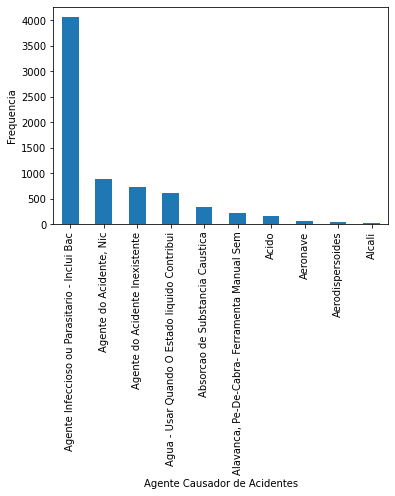

In [ ]:
df_pd_final_1.groupby(['ag_causador_acidente']).size().head(10).sort_values(ascending=False).plot.bar(xlabel='Agente Causador de Acidentes', ylabel = 'Frequencia', rot=90)

In [ ]:
df_pd_final_1.dtypes

ag_causador_acidente       object
Data Acidente              object
CBO                        object
cid_10                     object
CNAE2.0 Empregador          int64
cnae_empregador_1          object
emitente_cat               object
especie_beneficio          object
filiacao_segurado          object
indica_obito_acidente      object
munic_empr                 object
natureza_lesao             object
orig_cad_cat               object
parte_corpo_atingida       object
Sexo                       object
Tipo do Acidente           object
UF  Munic.  Acidente       object
uf_munic_empregador        object
Data Acidente.1            object
Data Despacho Benefício    object
Data Acidente.2            object
data_nascimento            object
Data Emissão CAT           object
cnpj_empregador            object
dtype: object

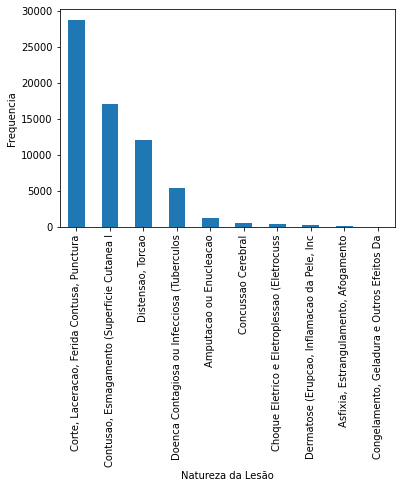

In [ ]:
#VERIFICAÇÃO DAS LESÕES QUE MAIS OCORRERAM.
df_pd_final_1.groupby(['natureza_lesao']).size().head(10).sort_values(ascending=False).plot.bar(xlabel='Natureza da Lesão', ylabel = 'Frequencia', rot=90)

In [ ]:
#VERIFICAÇÃO DAS MÉTRICAS ENTRE OCORRÊNCIAS DE ÓBITO COM AUXÍLIO DE PLOTAGEM
df_pd_final_1.groupby(['indica_obito_acidente']).size().sort_values(ascending=False)

indica_obito_acidente
Não    165684
Sim       873
dtype: int64

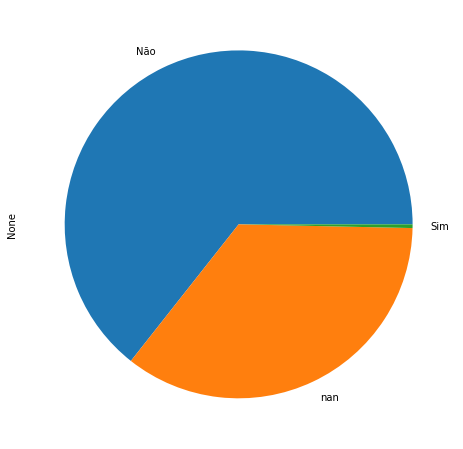

In [ ]:
df_pd_final_1.groupby(['indica_obito_acidente'],dropna=False).size().sort_values(ascending=False).plot.pie(figsize=(8,8))

In [ ]:
#VERIFICADO QUE DAS 873 INDICAÇÕES DE ÓBITO SOMENTE 1 ESTÁ RECEBENDO - 'Pensão por Morte Acidente do Trabalho'
df_pd_final_1.groupby(['especie_beneficio']).size().sort_values(ascending=False)

especie_beneficio
Pa                                         166540
Auxílio Doenca por Acidente do Trabalho     90692
Auxílio Acidente                              112
Aposent. Invalidez Acidente Trabalho           56
Pensão por Morte Acidente do Trabalho           1
dtype: int64

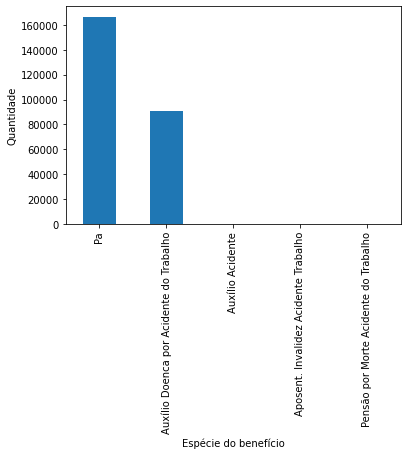

In [ ]:
#VERIFICAÇÃO DAS ESPÉCIES DO BENEFÍCIO, OU SEJA IDENTIFICAR AS MÉTRICAS DE QUANTOS ESTÃO RECEBENDO ALGUM TIPO DE BENEFÍCIO 
#EM RELAÇÃO AOS QUE SE ENCONTRAM EM PROCESSO ADMINISTRATIVO.
df_pd_final_1.groupby(['especie_beneficio']).size().head(10).sort_values(ascending=False).plot.bar(xlabel='Espécie do benefício', ylabel = 'Quantidade', rot=90)

In [ ]:
#VERIFICADO QUE A MAIORIA DOS ACIDENTES OCORRERAM COM INDIVÍDUOS DO SEXO MASCULINO
df_pd_final_1.groupby(['Sexo']).size().sort_values(ascending=False)

Sexo
Masculino        169484
Feminino          87095
Não Informado       819
Indeterminado         3
dtype: int64

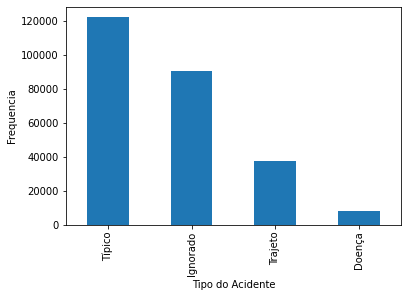

In [ ]:
#VERIFICADO QUE A MAIORIA DOS ACIDENTES SÃO DO TIPO TÍPICO
df_pd_final_1.groupby(['Tipo do Acidente']).size().head(10).sort_values(ascending=False).plot.bar(xlabel='Tipo do Acidente', ylabel = 'Frequencia', rot=90)

# PYSPARK
UTILIZAÇÃO DA BIBLIOTECA PYSPARK PARA DAR CONTINUIDADE AO TRATAMENTO DE DADOS.


In [ ]:
#CONFIGURAR A VARIÁVEL de AMBIENTE (SESSÃO) SPARK / VARIÁVEL DE SESSÃO QUE PERMITE O USO DO SPARK
spark = (
    SparkSession.builder
                .master('local')
                .appName('catweb')
                .getOrCreate()
)

In [ ]:
#MONTAGEM DO ESQUEMA DE COLUNAS CONTENDO A TIPAGEM DE CADA COLUNA VIA StructType
esquema = (
    StructType([
        StructField('agente_causador_acidente', StringType()),
        StructField('data_acidente', StringType()),
        StructField('cbo', StringType()),
        StructField('cid_10', StringType()),
        StructField('cnae2_empregador', IntegerType()),
        StructField('cnae2_empregador_1', StringType()),
        StructField('emitente_cat', StringType()),
        StructField('especie_beneficio', StringType()),
        StructField('filiacao_segurado', StringType()),
        StructField('indica_obito_acidente', StringType()),
        StructField('munic_empr', StringType()),
        StructField('natureza_da_lesao', StringType()),
        StructField('origem_cadastramento_cat', StringType()),
        StructField('parte_corpo_atingida', StringType()),
        StructField('sexo', StringType()),
        StructField('tipo_acidente', StringType()),
        StructField('uf_municipio_acidente', StringType()),
        StructField('uf_municipio_empregador', StringType()),
        StructField('data_acidente_1', StringType()),
        StructField('data_despacho_benefício', StringType()),
        StructField('data_acidente_2', StringType()),
        StructField('data_nascimento', StringType()),
        StructField('data_emissao_cat', StringType()),
        StructField('cnpj_cei_empregador', StringType())
    ])
)

In [ ]:
# CONVERSÃO DO DF, PANDAS PARA PYSPARK
df_spark = spark.createDataFrame(df_pd_final_1, schema=esquema)
df_spark.printSchema()
df_spark.show()

In [ ]:
#ANTES DE INICIAR O TRATAMENTO DE DADOS FAZ-SE NECESSÁRIO UM BACKUP, PARA EM CASO DE UM POSSÍVEL ERRO, OS DADOS ESTAREM ASSEGURADOS
df_spark_bckup = df_spark

# PRÉ ANÁLISE

In [ ]:
df_spark.printSchema()

In [ ]:
df_spark.show(truncate=False)

In [ ]:
df_spark.summary().show()

+-------+------------------------+-------------+--------------------+--------------------+------------------+--------------------+------------------+--------------------+-----------------+---------------------+---------------+--------------------+------------------------+--------------------+-------------+-------------+---------------------+-----------------------+---------------+-----------------------+---------------+---------------+----------------+--------------------+
|summary|agente_causador_acidente|data_acidente|                 cbo|              cid_10|  cnae2_empregador|  cnae2_empregador_1|      emitente_cat|   especie_beneficio|filiacao_segurado|indica_obito_acidente|     munic_empr|   natureza_da_lesao|origem_cadastramento_cat|parte_corpo_atingida|         sexo|tipo_acidente|uf_municipio_acidente|uf_municipio_empregador|data_acidente_1|data_despacho_benefício|data_acidente_2|data_nascimento|data_emissao_cat| cnpj_cei_empregador|
+-------+------------------------+----------

In [ ]:
df_spark.count()

257401

In [ ]:
df_spark_distinct = df_spark.distinct()
print('Distinct ns.: '+str(df_spark_distinct.count()))

Distinct ns.: 156749


# TRATAMENTO DE DADOS

In [ ]:
#DROPAGEM DE LINHAS DUPLICADAS
#FOI VERIFICADO NO MERGE DO PANDAS QUE O NÚMERO DE LINHAS RESULTANTE É O MESMO DA DROPAGEM AQUI NO PYSPARK. 
#CONSTAMOS AQUI QUE FIZEMOS NO PADAS O COMANDO CONCAT DAS DFS PARA CONSTAR A INTEGRIDADE DA SOMATÓRIA DE LINHAS DOS DFS E OPTAMOS POR DROPA-LAS NO PYSPARK

In [ ]:
df_spark = df_spark.dropDuplicates()

In [ ]:
# VERIFICAÇÃO DE LINHAS
print('Contagem atual de rows: '+str(df_spark.count()))

Contagem atual de rows: 156749


In [ ]:
#DROPAGEM DAS COLUNAS DE DATAS REPETIDAS COM VALORES MENORES
#data_acidente e data_acidente_1 CONSTAM APENAS INFORMAÇÕES PARCIAIS COMO MES E ANO, 
#ENQUANTO A  coluna data_acidente_2 CONSTA DIA, MES e ANO REFERENTE A DATA ACIDENTE.

In [ ]:
df_spark = df_spark.drop(*['data_acidente','data_acidente_1'])

In [ ]:
df_spark.printSchema()

In [ ]:
# RENOMEAR A COLUNA data_acidente_2 PARA 'data_acidente', PERMANECENDO UMA SÓ COLUNA PARA DATA
df_spark = df_spark.withColumnRenamed('data_acidente_2', 'data_acidente')

In [ ]:
df_spark.printSchema()

In [ ]:
df_spark.summary().show()

In [ ]:
#DROPAGEM DA COLUNA uf_municipio_acidente
#COLUNA INCONGRUENTE COM AS DEMAIS INFORMAÇÕES GEOGRÁFICAS CONSTANTES NO DF
df_spark = df_spark.drop('uf_municipio_acidente')

In [ ]:
df_spark.printSchema()

In [ ]:
df_spark.summary().show()

#FILTROS/SPARK

In [ ]:
df_spark.printSchema()

In [ ]:
#FILTRO DA ÚNICA PESSOA QUE RECEBEU PENSÃO POR MORTE
df_spark.filter(df_spark.especie_beneficio == 'Pensão por Morte Acidente do Trabalho').show(truncate=False)

+--------------------------------------------+------------------------------------+--------------------------------------------+----------------+----------------------------------+------------+-------------------------------------+-----------------+---------------------+----------------+-----------------+------------------------+---------------------------+---------+-------------+-----------------------+-----------------------+-------------+---------------+----------------+-------------------+
|agente_causador_acidente                    |cbo                                 |cid_10                                      |cnae2_empregador|cnae2_empregador_1                |emitente_cat|especie_beneficio                    |filiacao_segurado|indica_obito_acidente|munic_empr      |natureza_da_lesao|origem_cadastramento_cat|parte_corpo_atingida       |sexo     |tipo_acidente|uf_municipio_empregador|data_despacho_benefício|data_acidente|data_nascimento|data_emissao_cat|cnpj_cei_empregador|
+-

In [ ]:
df_spark.filter(df_spark.especie_beneficio == 'Pa').count()

116777

In [ ]:
#FILTRO DOS ACIDENTES QUE TIVERAM 'São Paulo' COMO UF DO EMPREGADOR
df_spark.filter(df_spark.uf_municipio_empregador == 'São Paulo').show(truncate=False)

In [ ]:
#FILTRO PARA RETORNO DA PROFISSÃO, SEXO, INDICAÇÃO DE ÓBITO E O TIPO DE ACIDENTE SOMENTE DAS PESSOAS QUE SOFRERAM ÓBITO
df_spark.select(F.col('cbo'), F.col('sexo'), F.col('indica_obito_acidente'), F.col('tipo_acidente')).filter(F.col('indica_obito_acidente') == 'Sim').show()

+--------------------+---------+---------------------+-------------+
|                 cbo|     sexo|indica_obito_acidente|tipo_acidente|
+--------------------+---------+---------------------+-------------+
|        517420-Vigia|Masculino|                  Sim|       Típico|
|862150-Oper. Máqu...|Masculino|                  Sim|      Trajeto|
|833120-Oper. Máqu...|Masculino|                  Sim|      Trajeto|
|623110-Trab. Pecu...|Masculino|                  Sim|       Típico|
|784205-Alimentado...|Masculino|                  Sim|      Trajeto|
|724205-Montador E...|Masculino|                  Sim|       Típico|
|       513405-Garçom|Masculino|                  Sim|      Trajeto|
|142105-Ger. Admin...| Feminino|                  Sim|      Trajeto|
|782410-Motorista ...|Masculino|                  Sim|       Típico|
|711320-Sondador d...|Masculino|                  Sim|      Trajeto|
|784205-Alimentado...|Masculino|                  Sim|      Trajeto|
|642005-Oper. Colh...|Masculino|  

In [ ]:
#FILTRO PARA RETORNO DA PROFISSÃO, SEXO, NATUREZA DA LESAO E O TIPO DE ACIDENTE SOMENTE DAS PESSOAS DE PESSOAS QUE SOFRERAM POR CAUSA DE DOENÇA
df_spark.select(F.col('cbo'), F.col('sexo'), F.col('natureza_da_lesao'), F.col('tipo_acidente')).filter(F.col('tipo_acidente') == 'Doença').show()

+--------------------+---------+--------------------+-------------+
|                 cbo|     sexo|   natureza_da_lesao|tipo_acidente|
+--------------------+---------+--------------------+-------------+
|422105-Recepcioni...| Feminino|Doenca Contagiosa...|       Doença|
|782310-Motorista ...|Masculino|Doenca Contagiosa...|       Doença|
|322205-Tec. de En...| Feminino|         Doenca, Nic|       Doença|
|231305-Prof. Ciên...|Masculino|Doenca Contagiosa...|       Doença|
|     412205-Contínuo| Feminino|         Doenca, Nic|       Doença|
|322230-Auxiliar d...| Feminino|Doenca Contagiosa...|       Doença|
|  421125-Oper. Caixa| Feminino|         Doenca, Nic|       Doença|
|322205-Tec. de En...| Feminino|Doenca Contagiosa...|       Doença|
|   223505-Enfermeiro| Feminino|Doenca Contagiosa...|       Doença|
|513205-Cozinheiro...| Feminino|Doenca Contagiosa...|       Doença|
|000000-n_classifi...| Feminino|   Distensao, Torcao|       Doença|
|515105-Agente Com...| Feminino|Doenca Contagios

In [ ]:
#FILTRO PARA RETORNO DA PROFISSÃO, SEXO, NATUREZA DA LESAO, INDICAÇÃO DE ÓBITO, TIPO DE ACIDENTE, DATA DE NASCIMENTO, PARTE DO CORPO ATINGIDA, DATA DO ACIDENTE DAS PESSOAS 
#QUE TIVERAM A CABEÇA COMO PARTE DO CORPO ATINGIDO
df_spark.select(F.col('cbo'), F.col('sexo'), F.col('natureza_da_lesao'), F.col('indica_obito_acidente'), F.col('tipo_acidente'), F.col('data_nascimento'), F.col('parte_corpo_atingida'), F.col('data_acidente')).filter(F.col('parte_corpo_atingida') == 'Cabeca, Nic').show(truncate=False)

+---------------------------------------------+---------+-------------------------------------------+---------------------+-------------+---------------+--------------------+-------------+
|cbo                                          |sexo     |natureza_da_lesao                          |indica_obito_acidente|tipo_acidente|data_nascimento|parte_corpo_atingida|data_acidente|
+---------------------------------------------+---------+-------------------------------------------+---------------------+-------------+---------------+--------------------+-------------+
|841810-Oper. Máquinas de Fabricação de Doces,|Feminino |Lesao Imediata                             |Não                  |Típico       |22/08/1990     |Cabeca, Nic         |02/03/2022   |
|848510-Açougueiro                            |Masculino|Corte, Laceracao, Ferida Contusa, Punctura |Não                  |Típico       |16/03/1987     |Cabeca, Nic         |12/03/2022   |
|000000-n_classificado                        |Masculin

In [ ]:
#FILTRO PARA RETORNO DA AGENTE CAUSADOR DO ACIDENTE, SEXO, NATUREZA DA LESAO, INDICAÇÃO DE ÓBITO E O TIPO DE ACIDENTE SOMENTE DAS PESSOAS DO SEXO FEMININO
df_spark.select(F.col('agente_causador_acidente'), F.col('sexo'), F.col('natureza_da_lesao'), F.col('indica_obito_acidente'), F.col('tipo_acidente')).filter(F.col('sexo') == 'Feminino').show(truncate=False)

+---------------------------------------------+--------+-------------------------------------------+---------------------+-------------+
|agente_causador_acidente                     |sexo    |natureza_da_lesao                          |indica_obito_acidente|tipo_acidente|
+---------------------------------------------+--------+-------------------------------------------+---------------------+-------------+
|Queda de Pes. com Dif. de Nivel em Esc       |Feminino|Lesao Imediata                             |Não                  |Típico       |
|Impacto de Pes. Contra Objeto em Movimento   |Feminino|Lesao Imediata                             |Não                  |Trajeto      |
|Escada Movel ou Fixada, Nic                  |Feminino|Contusao, Esmagamento (Superficie Cutanea I|Não                  |Típico       |
|Mobiliario e Acessorios, Nic                 |Feminino|Lesao Imediata                             |Não                  |Típico       |
|Queda de Pes. em Mesmo Nivel, Nic       

In [ ]:
#FILTRO PARA RETORNO DA AGENTE CAUSADOR DO ACIDENTE, CBO, SEXO, NATUREZA DA LESAO, TIPO DO ACIDENTE SOMENTE QUANDO O AGENTE CAUSADOR FOR BICICLETA
df_spark.select(F.col('agente_causador_acidente'), F.col('cbo'), F.col('sexo'), F.col('natureza_da_lesao'), F.col('tipo_acidente')).filter(F.col('agente_causador_acidente') == 'Bicicleta').show()


+------------------------+--------------------+---------+--------------------+-------------+
|agente_causador_acidente|                 cbo|     sexo|   natureza_da_lesao|tipo_acidente|
+------------------------+--------------------+---------+--------------------+-------------+
|               Bicicleta|513205-Cozinheiro...| Feminino|Contusao, Esmagam...|      Trajeto|
|               Bicicleta|000000-n_classifi...| Feminino|Contusao, Esmagam...|      Trajeto|
|               Bicicleta|765405-Trab. do A...|Masculino|Corte, Laceracao,...|      Trajeto|
|               Bicicleta|    517330-Vigilante|Masculino|             Fratura|       Típico|
|               Bicicleta|762005-Trab. Poli...|Masculino|             Fratura|      Trajeto|
|               Bicicleta|000000-n_classifi...|Masculino|             Fratura|      Trajeto|
|               Bicicleta|411005-Auxiliar d...|Masculino|Escoriacao, Abras...|      Trajeto|
|               Bicicleta|    783220-Estivador|Masculino|Contusao, Esm

In [ ]:
# Filtro para retorno do sexo e incidencia óbito
df_spark.select(F.col('sexo'), F.col('indica_obito_acidente'), F.col('sexo') == 'Feminino').filter(F.col('indica_obito_acidente') == 'Sim').show()

+---------+---------------------+-----------------+
|     sexo|indica_obito_acidente|(sexo = Feminino)|
+---------+---------------------+-----------------+
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
| Feminino|                  Sim|             true|
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
|Masculino|                  Sim|            false|
|Masculino| 

# WINDOW FUNCTIONS


In [ ]:
w0 = Window.orderBy('data_emissao_cat').partitionBy('indica_obito_acidente')
w1 = Window.orderBy('uf_municipio_empregador')
w2 = Window.orderBy('codigo_municipio')
w4 = Window.partitionBy('data_emissao_cat').orderBy('especie_beneficio')
w5 = Window.partitionBy('cid_10').orderBy('especie_beneficio')

In [ ]:
df_spark.withColumn('dense_rank', dense_rank().over(w1)).show()

+------------------------+--------------------+--------------------+----------------+--------------------+--------------+--------------------+-----------------+---------------------+---------------+--------------------+------------------------+--------------------+---------+-------------+-----------------------+-----------------------+-------------+---------------+----------------+-------------------+----------+
|agente_causador_acidente|                 cbo|              cid_10|cnae2_empregador|  cnae2_empregador_1|  emitente_cat|   especie_beneficio|filiacao_segurado|indica_obito_acidente|     munic_empr|   natureza_da_lesao|origem_cadastramento_cat|parte_corpo_atingida|     sexo|tipo_acidente|uf_municipio_empregador|data_despacho_benefício|data_acidente|data_nascimento|data_emissao_cat|cnpj_cei_empregador|dense_rank|
+------------------------+--------------------+--------------------+----------------+--------------------+--------------+--------------------+-----------------+--------

In [ ]:
df_spark = df_spark.withColumn('dense_rank', dense_rank().over(w5))

In [ ]:
df_spark = df_spark.withColumn('rank', rank().over(w4))

In [ ]:
df_spark.show()

# SPARKSQL

In [ ]:
#CRIAÇÃO DE TABELA EM SQL PARA EXECUTAR ALGUMAS QUERYS, UTILIZANDO A LINGUAGEM SQL.

In [ ]:
spark.sql('show databases').show()

+---------+
|namespace|
+---------+
|  default|
+---------+



In [ ]:
spark.sql('create database df_spark').show()

++
||
++
++



In [ ]:
spark.sql('show databases').show()

+---------+
|namespace|
+---------+
|  default|
| df_spark|
+---------+



In [ ]:
spark.sql('use df_spark')

DataFrame[]

In [ ]:
spark.sql('SHOW TABLES').show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+



In [ ]:
df_spark.write.saveAsTable('df_spark')

In [ ]:
spark.sql('show tables').show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
| df_spark| df_spark|      false|
+---------+---------+-----------+



In [ ]:
spark.sql('select * from df_spark').show()

+------------------------+--------------------+--------------------+----------------+------------------+--------------+--------------------+-----------------+---------------------+---------------+-----------------+------------------------+--------------------+---------+-------------+-----------------------+-----------------------+-------------+---------------+----------------+-------------------+----------+----+
|agente_causador_acidente|                 cbo|              cid_10|cnae2_empregador|cnae2_empregador_1|  emitente_cat|   especie_beneficio|filiacao_segurado|indica_obito_acidente|     munic_empr|natureza_da_lesao|origem_cadastramento_cat|parte_corpo_atingida|     sexo|tipo_acidente|uf_municipio_empregador|data_despacho_benefício|data_acidente|data_nascimento|data_emissao_cat|cnpj_cei_empregador|dense_rank|rank|
+------------------------+--------------------+--------------------+----------------+------------------+--------------+--------------------+-----------------+----------

# INSIGHTS SPARKSQL

In [ ]:
#INSIGHT 1 - ORDENAÇÃO DA NATUREZA DA LESÃO POR ORDEM ALFABÉTICA
spark.sql('select natureza_da_lesao FROM df_spark ORDER BY natureza_da_lesao asc;').show(truncate=False)

+-----------------------+
|natureza_da_lesao      |
+-----------------------+
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
|Amputacao ou Enucleacao|
+-----------------------+
only showing top 20 rows



In [ ]:
#INSIGHT 2 - EXIBIÇÃO DE TODAS AS OCORRÊNCIAS DE ÓBITOS
spark.sql('select * FROM df_spark WHERE indica_obito_acidente = "Sim";').show(truncate=False)

+---------------------------------------------+---------------------------------------------+---------------------------------------------+----------------+---------------------------------------------+--------------+-----------------+-----------------+---------------------+-----------------------------+-------------------------------------------+------------------------+---------------------------------------------+---------+-------------+-----------------------+-----------------------+-------------+---------------+----------------+-------------------+----------+----+
|agente_causador_acidente                     |cbo                                          |cid_10                                       |cnae2_empregador|cnae2_empregador_1                           |emitente_cat  |especie_beneficio|filiacao_segurado|indica_obito_acidente|munic_empr                   |natureza_da_lesao                          |origem_cadastramento_cat|parte_corpo_atingida                         |sexo

In [ ]:
#INSIGHT 3 - SELEÇÃO DE TODOS OS ACIDENTES QUE 'Animal Vivo' como AGENTE CAUSADOR DO ACIDENTE
spark.sql('select * FROM df_spark WHERE agente_causador_acidente = "Animal Vivo";').show(truncate=False)

+------------------------+--------------------------------------------+---------------------------------------------+----------------+---------------------------------------------+------------+-----------------+-----------------+---------------------+---------------------+-------------------------------------------+------------------------+---------------------------------------------+---------+-------------+-----------------------+-----------------------+-------------+---------------+----------------+-------------------+----------+----+
|agente_causador_acidente|cbo                                         |cid_10                                       |cnae2_empregador|cnae2_empregador_1                           |emitente_cat|especie_beneficio|filiacao_segurado|indica_obito_acidente|munic_empr           |natureza_da_lesao                          |origem_cadastramento_cat|parte_corpo_atingida                         |sexo     |tipo_acidente|uf_municipio_empregador|data_despacho_benefí

In [ ]:
#INSIGHT 4 - SELEÇÃO DOS ACIDENTES QUE TIVERAM O DEDO COMO PARTE DO CORPO ATINGIDA
spark.sql('select * FROM df_spark WHERE parte_corpo_atingida = "Dedo";').show(truncate=False)

+---------------------------------------------+---------------------------------------------+---------------------------------------+----------------+---------------------------------------------+-------------------+-----------------+-----------------+---------------------+------------------------+-------------------------------------------+------------------------+--------------------+---------+-------------+-----------------------+-----------------------+-------------+---------------+----------------+-------------------+----------+----+
|agente_causador_acidente                     |cbo                                          |cid_10                                 |cnae2_empregador|cnae2_empregador_1                           |emitente_cat       |especie_beneficio|filiacao_segurado|indica_obito_acidente|munic_empr              |natureza_da_lesao                          |origem_cadastramento_cat|parte_corpo_atingida|sexo     |tipo_acidente|uf_municipio_empregador|data_despacho_bene

In [ ]:
#INSIGHT 5 - SELECÃO DOS ACIDENTES QUE OCORRERAM COM PESSOAS QUE SÃO ENFERMEIRO(A)
spark.sql('select * FROM df_spark WHERE cbo = "223505-Enfermeiro";').show(truncate=False)

+---------------------------------------------+-----------------+------------------------------------+----------------+---------------------------------------------+-------------------+-----------------+-----------------+---------------------+-----------------------+-------------------------------------------+------------------------+---------------------------------------------+---------+-------------+-----------------------+-----------------------+-------------+---------------+----------------+-------------------+----------+----+
|agente_causador_acidente                     |cbo              |cid_10                              |cnae2_empregador|cnae2_empregador_1                           |emitente_cat       |especie_beneficio|filiacao_segurado|indica_obito_acidente|munic_empr             |natureza_da_lesao                          |origem_cadastramento_cat|parte_corpo_atingida                         |sexo     |tipo_acidente|uf_municipio_empregador|data_despacho_benefício|data_aci

In [ ]:
#INSIGHT 6 - ORDENAÇÃO DOS MUNICÍPIOS EM ORDEM ALFABÉTICA.
spark.sql('select uf_municipio_empregador FROM df_spark ORDER BY uf_municipio_empregador asc;').show(truncate=False)

# CONVERSÃO PARA PANDAS 

In [ ]:
#OPTAMOS POR CONVERTER PARA O PANDAS PARA FACILITAR O ENVIO DOS ARQUIVOS PARA OS BANCOS.

In [ ]:
df_pandas = df_spark.toPandas()

In [ ]:
df_catweb_tratado = df_pandas.copy

#INSTALAÇÃO DAS BIBLIOTECAS DO CONECTOR MYSQL

In [ ]:
!pip install mysql-connector-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.5 MB 1.7 MB/s 


In [ ]:
!pip install pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.5 MB/s 


In [ ]:
import mysql.connector
import pymysql
from sqlalchemy import create_engine

In [ ]:
import google.auth
from google.auth.transport.requests import Request
import sqlalchemy


#ENVIO PARA O BUCKET NA GCP

In [ ]:
df_pandas.to_csv()

In [ ]:
#IMPORTAÇÃO DO DF TRATADO PARA O BUCKET
df_pandas.to_csv('gs://bc26-datasets-ivana/catweb_tratado_export.csv',storage_options={'token':'token_gcp'})

#ENVIO PARA MYSQL

In [ ]:
conexao = 'ip_address'
nome_do_banco = 'database_name'
usuario = 'user'
senha = 'password' 
engine = create_engine( "mysql+pymysql://{user}:{pw}@{host}/{db}"
              .format(host=conexao, db=nome_do_banco, user= usuario, pw=senha))

df_pandas.to_sql("df_pandas",engine,index=True,index_label='id')

#ENVIO PARA O MONGO

In [ ]:
#CONECTOR DO MONGO ATLAS
uri = "url_mongo_db"
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile='certificate_key')

In [ ]:
#ESCOLHA DO DATABASE E COLEÇÃO - ORIG
db = client['catweb_tratado'] #DATABASE
colecao_catweb = db['catweb_db_tratado'] #COLEÇÃO
db_tratado = client['catweb_db_tratado']
colecao_tratado = db['catweb_tratado']

In [ ]:
df_catweb_tratado = df_pandas.to_dict("records")
colecao_tratado.insert_many(df_catweb_tratado)

In [ ]:
colecao_tratado.count_documents({})

#FIM DO PROCESSO